In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes , linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
color = sns.color_palette()
eng_stopwords = set(stopwords.words("english"))

In [2]:
train = pd.read_csv('./f2c2f440-8-dataset_he/train.csv')
test = pd.read_csv('./f2c2f440-8-dataset_he/test.csv')
print "Rows in train  ", train.shape[0]
print "Rows in test ", test.shape[0]

Rows in train   38932
Rows in test  29404


In [3]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


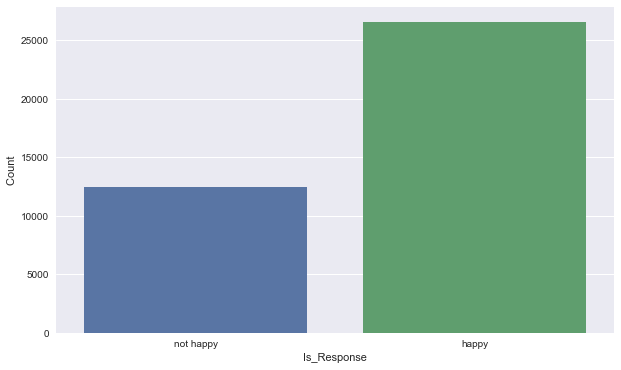

happy        26521
not happy    12411
Name: Is_Response, dtype: int64


In [4]:
plt.figure(figsize=(10 ,6))
sns.countplot(train.Is_Response)
plt.ylabel(" Count ")
plt.show()
print train.Is_Response.value_counts()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train.Device_Used = le.fit_transform(train.Device_Used)
test.Device_Used = le.transform(test.Device_Used)


Let's do feature Engineering 

From text data, we can get 2 types of features
1 . Meta Fetures - num of words , number of punctuations , length of the text , number of stop words
2 . Text features - frequency

In [6]:
#Meta Features

#number of words
train['no_words'] = train['Description'].apply(lambda x : len(str(x).split()))
test['no_words'] = test['Description'].apply(lambda x : len(str(x).split()))

#number of punctuations
train['no_punctuation'] = train['Description'].apply(lambda x: len([w for w in str(x).lower().split() if w in string.punctuation]))
test['no_punctuation'] = test['Description'].apply(lambda x: len([w for w in str(x).lower().split() if w in string.punctuation]))

#length of text
train['len_description'] = train['Description'].apply(lambda x : len(str(x)))
test['len_description'] = test['Description'].apply(lambda x : len(str(x)))

#number of stop words
train['no_stop_words'] = train['Description'].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))
test['no_stop_words'] = test['Description'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

train["num_words_upper"] = train["Description"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["Description"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))




In [7]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response,no_words,no_punctuation,len_description,no_stop_words,num_words_upper
0,id10326,The room was kind of clean but had a VERY stro...,Edge,1,not happy,46,0,248,24,1
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,1,not happy,208,1,1077,99,8
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,2,not happy,232,0,1327,111,9
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,0,happy,93,0,502,40,0
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,2,not happy,297,3,1613,148,7


In [8]:
#Text Fatures using TFIDF Vectorizer

tfidf = TfidfVectorizer(ngram_range=(1,3) )
tfidf_all = tfidf.fit_transform(train.Description.tolist() + test.Description.tolist())
train_tfidf = tfidf.transform(train.Description.tolist())
test_tfidf = tfidf.transform(test.Description.tolist())

In [9]:
def changeToBinary(x):
    if x == 'not happy':
        return 0
    else :
        return 1

In [10]:
train['Is_Response'] = train.Is_Response.apply(lambda x : changeToBinary(x))

In [16]:
drop_list = ['User_ID' , 'Description' , 'Browser_Used' ,'no_stop_words' ]
X_train = train.drop(drop_list + ['Is_Response'] , axis=1)
X_test = test.drop(drop_list , axis=1)

In [17]:
y_train = train.Is_Response

In [18]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [22]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 2])
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(X_train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = y_train[dev_index], y_train[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    print "CV Score - 1 ", cv_scores
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

CV Score - 1  [0.35216525404338173]
CV Score - 1  [0.35216525404338173, 0.34785009851861309]
CV Score - 1  [0.35216525404338173, 0.34785009851861309, 0.35041635227345563]
('Mean cv score : ', 0.3501439016118168)


In [23]:
columns = ['p_0' , 'p_1']
train_probability = pd.DataFrame(pred_train , columns=columns)
X_train['p_0'] = train_probability[['p_0']]
X_train['p_1'] = train_probability[['p_1']]

In [24]:
y_prob_df = pd.DataFrame(pred_full_test , columns=columns)

In [25]:
X_test['p_0'] = y_prob_df[['p_0']]
X_test['p_1'] = y_prob_df[['p_1']]

In [39]:
from sklearn.cross_validation import cross_val_score
clf = xgb.XGBClassifier()
np.mean(cross_val_score(clf , X_train , y_train , cv =5))

0.88698266718964458

In [40]:
clf.fit(X_train , y_train)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1)

In [41]:
def changeToString(x):
    if x == 0:
        return 'not_happy'
    else :
        return 'happy'

In [42]:
y = clf.predict(X_test)
test['Is_Response'] = y
test['Is_Response'] = test['Is_Response'].apply(lambda x :changeToString(x) )

In [43]:
test[['User_ID' , 'Is_Response']].to_csv('./result.csv' , index=False)